In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_ as clip_grad

### Model/function definitions

In [ ]:
class HyperCube(nn.Module):
    def __init__(self,n,r):
        super().__init__()
        A_,B_,C_ = torch.rand(n,r,r), torch.rand(n,r,r), torch.rand(n,r,r)
        self.factors = nn.ParameterList([A_,B_,C_])
        
    def HyperCube_product(self):
        n = self.factors[0].shape[0]
        return torch.einsum('aij,bjk,cki->abc',*self.factors)/n 
    
    def evaluate(self,Target):
        T = self.HyperCube_product()
        loss = ((T-Target)**2).mean()
        return loss
    
    def factor_norms(self):
        norms = []
        for factor in self.factors:
            norms.append(factor.norm())
        return torch.stack(norms).detach()

In [3]:
class HyperCube2(nn.Module):
    def __init__(self,n1,n2,n3,r):
        super().__init__()
        A_,B_,C_ = torch.rand(n1,r,r), torch.rand(n2,r,r), torch.rand(n3,r,r)
        self.factors = nn.ParameterList([A_,B_,C_])
        
    def HyperCube_product(self):
       # n = self.factors[0].shape[0]
        return torch.einsum('aij,bjk,cki->abc',*self.factors)
    
    def evaluate(self,Target):
        T = self.HyperCube_product()
        loss = ((T-Target)**2).mean()
        return loss
    
    def factor_norms(self):
        norms = []
        for factor in self.factors:
            norms.append(factor.norm())
        return torch.stack(norms).detach()

In [17]:
## HyperCube SVD

def HC_SVD(factor_list): 
    A,B,C = [T.detach().cpu() for T in factor_list]
    ABC = {'A':A,'B':B,'C':C}

    hc_svd = {}
    R_prev = None

    for t, T in ABC.items():

        TL = T.permute(0,2,1).flatten(start_dim=0,end_dim=1)
        lL, sigL, rL = TL.svd()

        TR = T.flatten(start_dim=0,end_dim=1)
        lR, sigR, rR = TR.svd()

        if R_prev is not None:
            overlap = R_prev.T@rL

            sign = overlap.diag().sign()
            rL = rL @ sign.diag()
            # rR = rR @ sign.diag()

            core = torch.einsum('ij, bjk, kl->bil', rL.T, T, rR)
        else:
            core = None

        hc_svd[t] = dict(core=core, R_vec=rR, L_vec=rL, Rs = rR*sigR, Ls = rL*sigL, Rsig = sigR, Lsig = sigL) 
        R_prev = rR
    
    ### sign correction for A rL
    rR, rL = hc_svd['A']['R_vec'], hc_svd['A']['L_vec']
    sign = (R_prev.T@rL).diag().sign()
    rL = rL * sign
    Acore = torch.einsum('ij, bjk, kl->bil', rL.T, ABC['A'], rR)
    hc_svd['A']['core'] = Acore; hc_svd['A']['L_vec'] = rL; hc_svd['A']['Ls'] *= sign; 

    return hc_svd 


In [57]:
def plot_tensor_slices(T, max_slices=5):
    i_max = min(max_slices,T.shape[0])
    fig, axs = plt.subplots(1, i_max)
    vmax = T.abs().max()
    for i in range(i_max):
        ax = axs[i]
        ax.matshow(T[i],  vmin=-vmax, vmax=vmax, cmap='seismic')
        # ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.savefig('HC_factors.png')

def plot_HC_SVD(model):
    # A,B,C = model.factors
    hc_svd = HC_SVD(model.factors)

    # plot_tensor_slices(A.detach())  
    plot_tensor_slices(hc_svd['A']['core'])
    # plot_tensor_slices(B.detach())  
    plot_tensor_slices(hc_svd['B']['core'])
    # plot_tensor_slices(C.detach())  
    plot_tensor_slices(hc_svd['C']['core'])

In [8]:
def train(model, target, epochs = 700, wd_decay=200, lr=400, momentum=0.9, weight_decay=0.00001, grad_clip = 1e-2):
    
    optim = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    l_all = []
    norm_all = []
    for t  in range(epochs):
        if t==(epochs-wd_decay):
            optim.param_groups[0]['weight_decay'] /= 100
        optim.zero_grad()
        loss = model.evaluate(target)
        loss.backward()
        clip_grad(model.parameters(), grad_clip)
        optim.step()
        l_all.append(loss.item())
        norm_all.append(model.factor_norms())
       # print("Iter:",t)
    return l_all, torch.stack(norm_all)

### Demo Experiment

#### Target low-rank tensor (in a HyperCube sense)

In [ ]:
target = HyperCube(n=17,r=3).HyperCube_product().detach()

##### Training without weight_decay

In [ ]:
model_wd0 = HyperCube(n=17,r=17)
l_all, norm_all = train(model_wd0, epochs = 200, wd_decay=0, lr=400, momentum=0.9, weight_decay=0, grad_clip = 1e-2)

In [ ]:
plt.semilogy(l_all)
plt.semilogy(norm_all)
plt.show()

In [ ]:
plot_HC_SVD(model_wd0)

##### Training with weight_decay

In [ ]:
model_low_rank = HyperCube(n=17,r=17)
l_all, norm_all = train(model_low_rank, epochs = 800, wd_decay=200, lr=400, momentum=0.9, weight_decay=0.00001, grad_clip = 1e-2)

In [ ]:
plt.semilogy(l_all)
plt.semilogy(norm_all)
plt.show()

In [ ]:
plot_HC_SVD(model_low_rank)

In [61]:
W = torch.load('tensor_Q.pt').detach()
idx1 = torch.randperm(W.size(0))[:300]
idx2 = torch.randperm(W.size(1))[:300]

W = W[idx1,:,:]
W = W[:,idx2,:]

In [77]:
#W1 = W.clone().detach()
n1, n2, n3 = W.size()
model_tlora = HyperCube2(n1=n1, n2=n2, n3=n3, r =20)
l_all, norm_all = train(model_tlora, target = W, epochs = 200, wd_decay=0, lr=10, momentum=0.9, weight_decay=0.00, grad_clip = 1e-2)

In [ ]:
target = HyperCube2(n1=10, n2 = 10, n3 = 20,r=3).HyperCube_product().detach()

In [ ]:
n1, n2, n3 = target.size()
model_tlora = HyperCube2(n1=n1, n2=n2, n3=n3, r =10)
l_all, norm_all = train(model_tlora, target, epochs = 200, wd_decay=0, lr=0.1, momentum=0.9, weight_decay=0, grad_clip = 1e-2)

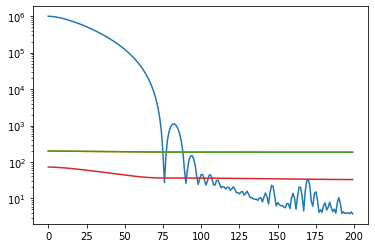

In [78]:
plt.semilogy(l_all)
plt.semilogy(norm_all)
plt.savefig('error-vs-iter3.png')
plt.show()

plot_HC_SVD(model_tlora)

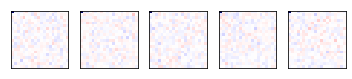

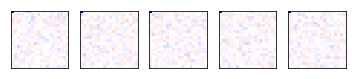

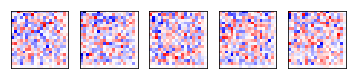

In [79]:
plot_HC_SVD(model_tlora)